In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from numpy.linalg import norm

## 2.21 Synthetic dataset

In [3]:
# positive dataset
cov = np.array([[1, 0],[0,1]])
mean = [2.5, 0]
pos = np.random.multivariate_normal(mean, cov, 750)
#add label
label_pos = np.ones((750,1))
pos_label = np.hstack((pos,label_pos))

In [4]:
# negative dataset
cov = np.array([[1, 0],[0,1]])
mean = [-2.5, 0]
neg = np.random.multivariate_normal(mean, cov, 750)
#add label
label_neg = np.zeros((750,1))
neg_label = np.hstack((neg,label_neg))

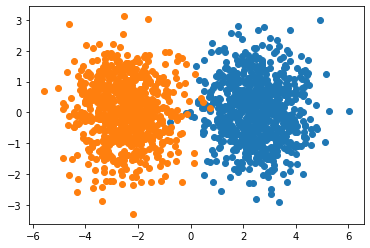

In [5]:
plt.scatter(pos[:,0], pos[:,1])
plt.scatter(neg[:,0], neg[:,1])

In [6]:
posneg = np.vstack((pos_label, neg_label))

In [7]:
df_data = pd.DataFrame()
df_data['feat1'] = posneg[:, 0]
df_data['feat2'] = posneg[:, 1]
df_data['labels'] = posneg[:, 2]

In [8]:
df_data

feat1     feat2  labels
0     2.872743 -0.169905     1.0
1     1.823973  2.820295     1.0
2     2.844651 -0.278087     1.0
3     1.755985 -0.097707     1.0
4     1.800064  0.545557     1.0
...        ...       ...     ...
1495 -3.734399 -1.122579     0.0
1496 -2.300741 -0.218064     0.0
1497 -3.149735  1.334625     0.0
1498 -5.566332  0.702541     0.0
1499 -1.265738  0.591432     0.0

[1500 rows x 3 columns]

In [9]:
def train_val_test(data, train_size, val_size):
    # random shuffle
    data = data.sample(frac=1)
    train = data[:train_size]
    val = data[train_size:train_size+val_size]
    test = data[train_size+val_size:]
    return train, val, test

In [10]:
train, val, test = train_val_test(df_data, 1000 , 250)

In [11]:
train

feat1     feat2  labels
1047 -1.488375 -0.840898     0.0
98    3.751883  1.917830     1.0
1413 -1.952909  0.026482     0.0
118   1.244485 -0.164815     1.0
1385 -1.252664 -1.423032     0.0
...        ...       ...     ...
622   1.384822  0.620261     1.0
1097 -1.738825  0.826107     0.0
317   2.332314  0.331795     1.0
862  -0.219872  0.972018     0.0
100   2.729099  1.478763     1.0

[1000 rows x 3 columns]

2.1 Linear SVM

In [256]:
iteration = 1000
lr = 0.1
X_train = np.array(train[['feat1','feat2']])
Y_train = np.array(train['labels'])
X_val = np.array(val[['feat1','feat2']])
Y_val = np.array(val['labels'])
X_test = np.array(test[['feat1','feat2']])
Y_test = np.array(test['labels'])

In [464]:
class SVM_linear:

    def __init__(self, lr=0.001, C=0.01, iteration=1000):
        self.lr = lr
        self.C = C
        self.iteration = iteration
        self.w = None
        self.b = None


    def fit(self, X, y):
        n, n_features = X.shape
        #
        y = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0
        
        for i in range(self.iteration):
            for ind, x_i in enumerate(X):
                
                if 1 - y[ind] * (np.dot(x_i, self.w) + self.b) <= 0:
                    self.w -= self.lr * (self.C * self.w)
                else:
                    self.w -= self.lr * (self.C * self.w - np.dot(x_i, y[ind]))
                    self.b += self.lr * y[ind]

        return self.w, self.b
    
    def predict(self, X):
        pred = np.dot(X, self.w) + self.b
        # convert to 0 1
        out = np.where(pred <= 0, 0, 1)
        return out 


In [259]:
svm = SVM_linear()

In [260]:
svm.fit(X_train, Y_train)

In [261]:
val_preds = svm.predict(X_val)

In [262]:
confusion_matrix(Y_val, val_preds)

array([[125,   0],
       [  0, 125]], dtype=int64)

In [265]:
train_preds = svm.predict(X_train)
confusion_matrix(Y_train, train_preds)

array([[494,   2],
       [  3, 501]], dtype=int64)

In [234]:
accuracy_score(Y_val, val_preds)

1.0

2.1 Kernel SVM

In [511]:
class SVM:
    def __init__(self, kernel='linear', C=10000, iteration=1000, degree=3, gamma=1):
        
        self.kernel = {'linear': lambda x,y: np.dot(x, y.T),
        'poly': lambda x,y: np.dot(x, y.T)**degree,
        'rbf': lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1))}[kernel]
                      
        self.C = C
        self.iteration = iteration

    def square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]
        
    def fit(self, X, y):
        self.X = X.copy()
        self.y = np.where(y <= 0, -1, 1)
        self.W = np.zeros(len(self.X))
        self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
        #print(self.K.shape, self.X.shape)
        for _ in range(self.iteration):
            for indM in range(len(self.X)):
                indL = np.random.randint(0, len(self.W))
                Q = self.K[[[indM, indM], [indL, indL]], [[indM, indL], [indM, indL]]]
                k0 = 1 - np.sum(self.W * self.K[[indM, indL]], axis=1)
                u = np.array([-self.y[indL], self.y[indM]])
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
                self.W[[indM, indL]] += u * self.square(t_max, self.W[[indM, indL]], u)

        idx = (self.W > 0)
        self.b = np.mean((1.0 - np.sum(self.K[idx] * self.W, axis=1)) * self.y[idx])
        return self.W, self.b

    def decision_function(self, X):
        return np.sum(self.kernel(X, self.X) * self.y * self.W, axis=1) + self.b

    def predict(self, X):
        return (np.sign(self.decision_function(X)) + 1) // 2

In [459]:
svm = SVM(kernel='linear', C=10, iteration=60)

In [460]:
W, b = svm.fit(X_train, Y_train)

(1000, 1000) (1000, 2)


In [86]:
val_pred = svm.predict(X_val)

In [87]:
confusion_matrix(Y_val, val_pred)

array([[126,   1],
       [  0, 123]], dtype=int64)

In [88]:
svm = SVM(kernel='poly', C=10, iteration=600)
W, b = svm.fit(X_train, Y_train)
val_pred = svm.predict(X_val)
print('val', confusion_matrix(Y_val, val_pred))
train_pred = svm.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred))

val [[126   1]
 [  0 123]]
train [[497   4]
 [  4 495]]


In [77]:
svm = SVM(kernel='rbf', C=100, iteration=600)
W, b = svm.fit(X_train, Y_train)
val_pred = svm.predict(X_val)
confusion_matrix(Y_val, val_pred)
train_pred = svm.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred))

train [[499   2]
 [  1 498]]


2.1 Logistic

In [659]:
x = y = X_train
np.exp(-gamma*(np.sum(x ** 2, axis=-1)[:, None] + np.sum(y ** 2, axis=-1)[None, :] - 2 * np.dot(x, y.T)))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [663]:
class Logistic:
    def __init__(self, kernel='linear', C=10000, iteration=1000, degree=3, gamma=1, learning_rate = 0.001, verbosity = False):
        
        self.kernel = {'no_kernel': 'no_kernel',
        'linear': lambda x,y: np.dot(x, y.T),
        'poly': lambda x,y: np.dot(x, y.T)**degree,
        'rbf': lambda x,y: np.exp(-gamma*(np.sum(x ** 2, axis=-1)[:, None] + np.sum(y ** 2, axis=-1)[None, :] - 2 * np.dot(x, y.T)))}[kernel]
                      
        self.C = C
        self.lr = learning_rate
        self.iteration = iteration
        self.verbosity = verbosity

    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))
        
    def loss(y, y_hat):
        return -np.mean(y * (np.log(y_hat)) - (1 - y) * np.log(1 - y_hat))
    
    def square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]
        
    def fit(self, X, y):
        self.X = X
        n_samples, n_features = X.shape
        self.y = y
        if self.kernel == 'no_kernel':
            self.K = self.X
        else:
            self.K = self.kernel(self.X, self.X)
            #print(self.K)
            #self.K[self.K < 0] = 0
        #print(self.K)
        self.W = np.zeros(self.K.shape[1])
        self.b = 0
        for it in range(self.iteration):
            
            y_hat = self.sigmoid(np.dot(self.K, self.W) + self.b)
            #print('yhat', y_hat)
            #print('dy', y, y_hat, y_hat-self.y)
            self.W += self.lr * np.dot(self.K.T, self.y - y_hat)
            #print('w', self.W)
            self.b += self.lr * np.sum(self.y - y_hat)
            loss = -np.sum( y*y_hat - np.log(1 + np.exp(y_hat)))
            if self.verbosity == True:
                if it % 10 ==0:
                    print('loss', it, loss)
            #print(y*(np.log(y_hat)), (1-y)*np.log(1-y_hat))
        return self.W, self.b


    def predict(self, X):
        if self.kernel == 'no_kernel':
            z = self.sigmoid(np.dot(X, self.W) + self.b)
        else:
            z = self.sigmoid(np.dot(self.kernel(X, self.X), self.W) + self.b)
        return (z>0.5).astype('int')

In [664]:
logr = Logistic(kernel='rbf', C=10000, iteration=10000, learning_rate=0.001)
W, b = logr.fit(X_train, Y_train)
val_pred = logr.predict(X_val)
print('val', confusion_matrix(Y_val, val_pred))
train_pred = logr.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred), accuracy_score(Y_train, train_pred))

val [[126   1]
 [  0 123]]
train [[498   3]
 [  1 498]] 0.996


In [643]:
logr = Logistic(kernel='no_kernel', C=100, iteration=100, verbosity = True)
W, b = logr.fit(X_train, Y_train)
val_pred = logr.predict(X_val)
print('val', confusion_matrix(Y_val, val_pred))
train_pred = logr.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred), accuracy_score(Y_train, train_pred))
test_pred = logr.predict(X_test)
print('test', confusion_matrix(Y_test, test_pred), accuracy_score(Y_test, test_pred))


loss 0 724.5769841801066
loss 10 520.1449512357824
loss 20 516.2594490171264
loss 30 514.4834467421819
loss 40 513.4266700652444
loss 50 512.7113127175895
loss 60 512.1881805519733
loss 70 511.78536566976163
loss 80 511.46352926052214
loss 90 511.19916077437534
val [[126   1]
 [  0 123]]
train [[497   4]
 [  3 496]] 0.993
test [[121   1]
 [  1 127]] 0.992


In [644]:
# tune hyperprameters
logr = Logistic(kernel='linear', C=10000, iteration=50)
W, b = logr.fit(X_train, Y_train)
val_pred = logr.predict(X_val)
print('val', confusion_matrix(Y_val, val_pred))
train_pred = logr.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred), accuracy_score(Y_train, train_pred))

ValueError: operands could not be broadcast together with shapes (250,1000) (1000,1) 

In [637]:
logr = Logistic(kernel='poly', C=1000, iteration=50)
W, b = logr.fit(X_train, Y_train)
val_pred = logr.predict(X_val)
print('val', confusion_matrix(Y_val, val_pred))
train_pred = logr.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred), accuracy_score(Y_train, train_pred))

val [[126   1]
 [  0 123]]
train [[497   4]
 [  3 496]] 0.993


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [444]:
logr = Logistic(kernel='poly', C=1000, iteration=50)
W, b = logr.fit(X_train, Y_train)
val_pred = logr.predict(X_val)
print('val', confusion_matrix(Y_val, val_pred))
train_pred = logr.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred), accuracy_score(Y_train, train_pred))

loss 0 724.5769841801066
loss 10 554.0825240493618
loss 20 531.17241135392
loss 30 522.602851315841
loss 40 518.2304807537582
val [[126   1]
 [  0 123]]
train [[497   4]
 [  3 496]] 0.993


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


In [650]:
logr = Logistic(kernel='rbf', C=10000, iteration=10000, learning_rate=0.001)
W, b = logr.fit(X_train, Y_train)
val_pred = logr.predict(X_val)
print('val', confusion_matrix(Y_val, val_pred))
train_pred = logr.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred), accuracy_score(Y_train, train_pred))

TypeError: 'numpy.float64' object does not support item assignment

In [638]:
logr = Logistic(kernel='rbf', C=10000, iteration=10000, learning_rate=0.001)
W, b = logr.fit(X_train, Y_train)
val_pred = logr.predict(X_val)
print('val', confusion_matrix(Y_val, val_pred))
train_pred = logr.predict(X_train)
print('train', confusion_matrix(Y_train, train_pred), accuracy_score(Y_train, train_pred))

val [[122   5]
 [  0 123]]
train [[479  22]
 [  0 499]] 0.978


2.2.1 Synthetic dataset

In [265]:
# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

In [467]:
# Linear SVM
svm_linear = SVM_linear()
W, b = svm_linear.fit(X_train, Y_train)
test_preds = svm.predict(X_test)
print(accuracy_score(Y_test, test_preds))

0.992


In [308]:
pos_test = test[test['labels']==1]
neg_test = test[test['labels']==0]

In [468]:
x_min, x_max = -6, 6
y_min, y_max = -3, 3
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Text(0.5, 1.0, 'Linear SVM Decision Boundary and True Labels')

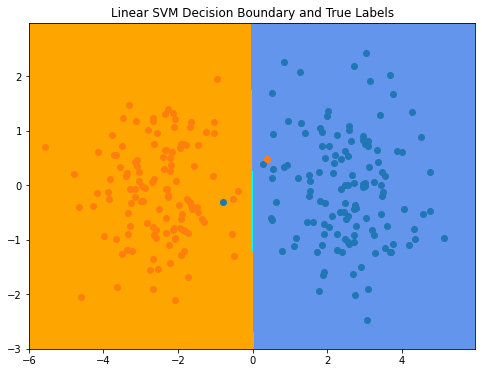

In [469]:
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(pos_test['feat1'], pos_test['feat2'])
plt.scatter(neg_test['feat1'], neg_test['feat2'])
plt.title('Linear SVM Decision Boundary and True Labels')

In [471]:
# Logistic Regression
logr = Logistic(kernel='no_kernel', C=100, iteration=100)
W, b = logr.fit(X_train, Y_train)
test_pred = logr.predict(X_test)
print('test', confusion_matrix(Y_test, test_pred), accuracy_score(Y_test, test_pred))

test [[121   1]
 [  1 127]] 0.992


Text(0.5, 1.0, 'Logistic Regression Decision Boundary and True Labels')

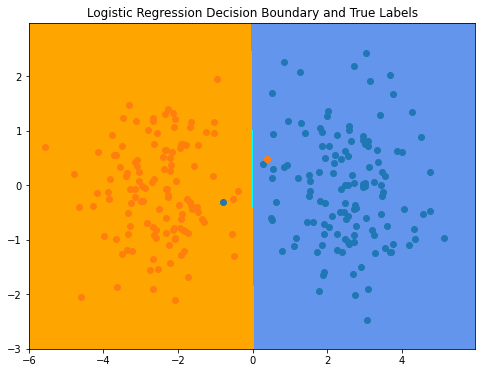

In [473]:
# plot decision boundary for logistic regression
x_min, x_max = -6, 6
y_min, y_max = -3, 3
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(pos_test['feat1'], pos_test['feat2'])
plt.scatter(neg_test['feat1'], neg_test['feat2'])
plt.title('Logistic Regression Decision Boundary and True Labels')

In [264]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import BernoulliNB as NB
from matplotlib.colors import ListedColormap

In [306]:
# tune hyperparameters, NB
best_model = None
best_accuracy = 0
for alpha in [0.001, 1, 10]:
    nb = NB(alpha = alpha)
    y_pred_nb = nb.fit(X_train, Y_train).predict(X_val)
    accuracy = accuracy_score(Y_val, y_pred_nb)
    print(accuracy, alpha)
    if accuracy>best_accuracy:
        best_model = nb
y_pred_nb = best_model.predict(X_test)
print('test accuracy',accuracy_score(Y_test, y_pred_nb))

0.996 0.001
0.996 1
0.996 10
test accuracy 0.992


In [307]:
x_min, x_max = -6, 6
y_min, y_max = -3, 3
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Text(0.5, 1.0, 'Naive Bayes Decision Boundary and True Labels')

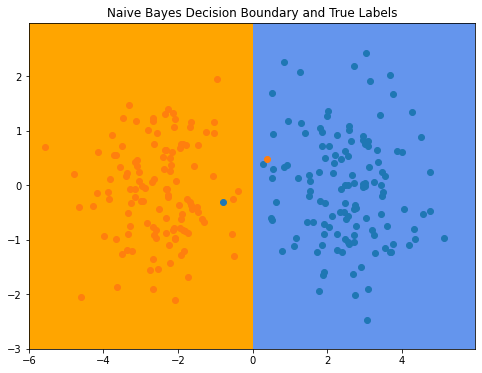

In [309]:
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(pos_test['feat1'], pos_test['feat2'])
plt.scatter(neg_test['feat1'], neg_test['feat2'])
plt.title('Naive Bayes Decision Boundary and True Labels')

KNN

In [316]:
# tune hyperparameters
for n in [1, 2, 3, 5, 10]:
    neigh = KNN(n_neighbors=n)
    y_pred_nb = neigh.fit(X_train, Y_train).predict(X_val)
    accuracy = accuracy_score(Y_val, y_pred_nb)
    print(accuracy, alpha)
    if accuracy>best_accuracy:
        best_model_neigh = neigh
y_pred_nb = best_model.predict(X_test)
print('test accuracy',accuracy_score(Y_test, y_pred_nb))

0.992 10
0.988 10
0.996 10
0.996 10
0.996 10
test accuracy 0.992


In [317]:
Z = best_model_neigh.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Text(0.5, 1.0, 'KNN Decision Boundary and True Labels')

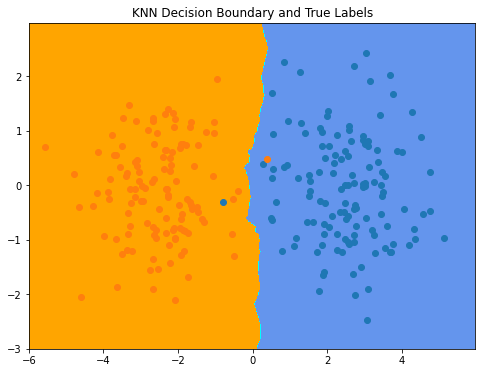

In [318]:
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(pos_test['feat1'], pos_test['feat2'])
plt.scatter(neg_test['feat1'], neg_test['feat2'])
plt.title('KNN Decision Boundary and True Labels')

In [314]:
datasets = []
for mu in np.arange(1,2.4, 0.2):
    # positive dataset
    cov = np.array([[1, 0],[0,1]])
    mean = [mu, 0]
    pos = np.random.multivariate_normal(mean, cov, 750)
    #add label
    label_pos = np.ones((750,1))
    pos_label = np.hstack((pos,label_pos))
    
    # negative dataset
    cov = np.array([[1, 0],[0,1]])
    mean = [-mu, 0]
    neg = np.random.multivariate_normal(mean, cov, 750)
    #add label
    label_neg = np.zeros((750,1))
    neg_label = np.hstack((neg,label_neg))
    
    posneg = np.vstack((pos_label, neg_label))
    
    df_data = pd.DataFrame()
    df_data['feat1'] = posneg[:, 0]
    df_data['feat2'] = posneg[:, 1]
    df_data['labels'] = posneg[:, 2]
    
    datasets.append(train_val_test(df_data, 1000, 250))

In [329]:
datasets[0][0]

feat1     feat2  labels
166  0.855996 -0.042878     1.0
301  1.165549  0.817217     1.0
507  0.435038  0.321940     1.0
836 -0.369142  0.358497     0.0
756 -1.150061 -0.757189     0.0
..        ...       ...     ...
32   1.169752  1.296732     1.0
677  0.083551  0.900566     1.0
743  0.992069 -0.768443     1.0
226  1.501794  0.953140     1.0
982 -0.529675  0.442191     0.0

[1000 rows x 3 columns]

In [331]:
# KNN
test_accuracies_knn = []
for d in datasets:
    accuracy = 0
    # tune hyperparameters
    for n in [1, 2, 3, 5, 10]:
        neigh = KNN(n_neighbors=n)
        y_pred_nb = neigh.fit(d[0][['feat1', 'feat2']], d[0]['labels']).predict(d[1][['feat1', 'feat2']])
        accuracy = accuracy_score(d[1]['labels'], y_pred_nb)
        if accuracy>best_accuracy:
            best_model_neigh = neigh
    y_pred_nb = best_model_neigh.predict(d[2][['feat1', 'feat2']])
    test_accuracies_knn.append(accuracy_score(d[2]['labels'], y_pred_nb))

In [332]:
test_accuracies_knn

[0.816, 0.892, 0.88, 0.956, 0.952, 0.972, 0.996]

In [333]:
# NB
test_accuracies_nb = []
for d in datasets:
    accuracy = 0
    # tune hyperparameters
    for alpha in [0.001, 1, 10]:
        nb = NB(alpha = alpha)
        y_pred_nb = nb.fit(d[0][['feat1', 'feat2']], d[0]['labels']).predict(d[1][['feat1', 'feat2']])
        accuracy = accuracy_score(d[1]['labels'], y_pred_nb)
        if accuracy>best_accuracy:
            best_model = nb
    y_pred_nb = best_model.predict(d[2][['feat1', 'feat2']])
    test_accuracies_nb.append(accuracy_score(d[2]['labels'], y_pred_nb))

In [334]:
test_accuracies_nb

[0.848, 0.892, 0.888, 0.96, 0.964, 0.968, 1.0]

In [480]:
# Linear SVM
test_accuracies_lsvm = []
for d in datasets:
    accuracy = 0
    svm_linear.fit(np.array(d[0][['feat1', 'feat2']]), np.array(d[0]['labels']))
    y_pred_lsvm = svm_linear.predict(np.array(d[1][['feat1', 'feat2']]))
    accuracy = accuracy_score(np.array(d[1]['labels']), y_pred_lsvm)
    if accuracy > best_accuracy:
        best_model = svm_linear
    # predict test
    y_pred_lsvm = best_model.predict(np.array(d[2][['feat1', 'feat2']]))
    test_accuracies_lsvm.append(accuracy_score(np.array(d[2]['labels']), y_pred_lsvm))

In [481]:
# Logistic regression
test_accuracies_lr = []
for d in datasets:
    accuracy = 0
    lgr =  Logistic(kernel='no_kernel', iteration=100)
    lgr.fit(np.array(d[0][['feat1', 'feat2']]), np.array(d[0]['labels']))
    y_pred_lr = lgr.predict(np.array(d[1][['feat1', 'feat2']]))
    accuracy = accuracy_score(np.array(d[1]['labels']), y_pred_lr)
    if accuracy > best_accuracy:
        best_model = lgr
    y_pred_lr = best_model.predict(np.array(d[2][['feat1', 'feat2']]))
    test_accuracies_lr.append(accuracy_score(np.array(d[2]['labels']), y_pred_lr))

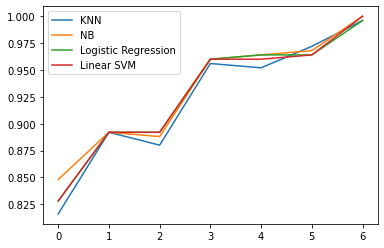

In [483]:
plt.plot(test_accuracies_knn)
plt.plot(test_accuracies_nb)
plt.plot(test_accuracies_lr)
plt.plot(test_accuracies_lsvm)
plt.legend(['KNN', 'NB', 'Logistic Regression', 'Linear SVM'])

2.2.2  Synthetic dataset circles

In [336]:
from sklearn.datasets import make_circles

In [339]:
circles = make_circles(n_samples=1500)

In [340]:
df_circles = pd.DataFrame()
df_circles['feat1'] = circles[0][:,0]
df_circles['feat2'] = circles[0][:,1]
df_circles['labels'] = circles[1]


In [490]:
train_circle, val_circle, test_circle = train_val_test(df_circles, 1000, 250)
X_train_circle = np.array(train_circle[['feat1', 'feat2']])
Y_train_circle = np.array(train_circle['labels'])
X_val_circle = np.array(val_circle[['feat1', 'feat2']])
Y_val_circle = np.array(val_circle['labels'])
X_test_circle = np.array(test_circle[['feat1', 'feat2']])
Y_test_circle = np.array(test_circle['labels'])

In [491]:
post_test_circles = test_circle[test_circle['labels']==1]
neg_test_circles = test_circle[test_circle['labels']==0]

In [493]:
# Linear SVM
svm_linear = SVM_linear()
W, b = svm_linear.fit(X_train_circle,Y_train_circle )
test_preds = svm.predict(X_test_circle)
print(accuracy_score(Y_test_circle, test_preds))

0.524


Text(0.5, 1.0, 'Linear SVM Decision Boundary and True Labels for Circle Data')

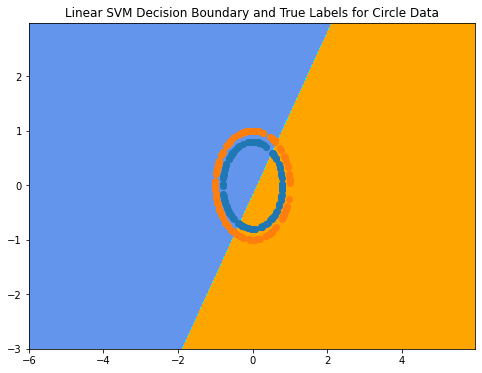

In [494]:
Z = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('Linear SVM Decision Boundary and True Labels for Circle Data')

In [665]:
# Logistic Regression
logr = Logistic(kernel='no_kernel', C=100, iteration=100)
W, b = logr.fit(X_train_circle, Y_train_circle)
test_pred = logr.predict(X_test_circle)
print('test', accuracy_score(Y_test_circle, test_pred))

test 0.488


Text(0.5, 1.0, 'Logistic Regression Decision Boundary and True Labels for Circle Data')

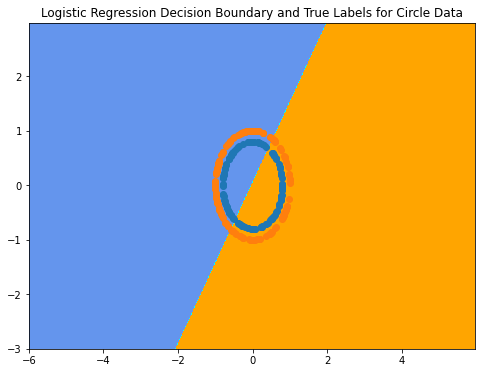

In [497]:
Z = logr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('Logistic Regression Decision Boundary and True Labels for Circle Data')

In [503]:
# Kernel SVM - linear
svm = SVM(kernel='linear', C=100, iteration=60)
W, b = svm.fit(X_train_circle, Y_train_circle)
test_pred = svm.predict(X_test_circle)
print('test', accuracy_score(Y_test_circle, test_pred))

(1000, 1000) (1000, 2)
test 0.436


Text(0.5, 1.0, 'SVM with Linear Kernel Decision Boundary and True Labels for Circle Data')

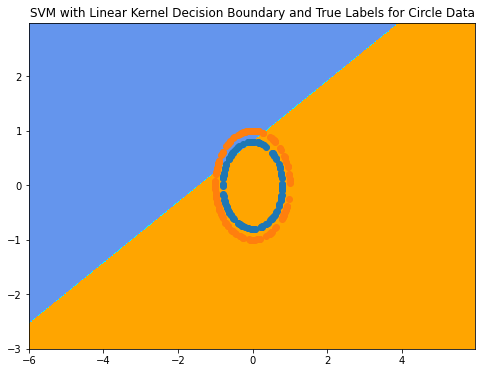

In [505]:
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('SVM with Linear Kernel Decision Boundary and True Labels for Circle Data')

In [509]:
# Kernel SVM - rbf
svm = SVM(kernel='rbf', C=100, iteration=60)
W, b = svm.fit(X_train_circle, Y_train_circle)
test_pred = svm.predict(X_test_circle)
print('test', accuracy_score(Y_test_circle, test_pred))

(1000, 1000) (1000, 2)
test 1.0


Text(0.5, 1.0, 'SVM with Linear Kernel Decision Boundary and True Labels for Circle Data')

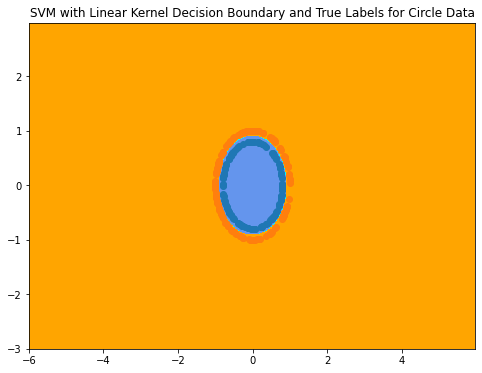

In [510]:
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('SVM with Linear Kernel Decision Boundary and True Labels for Circle Data')

In [523]:
# Kernel SVM - poly
for d in [2, 3, 4, 5]:
    svm = SVM(kernel='poly', C=100, iteration=60, degree = d)
    W, b = svm.fit(X_train_circle, Y_train_circle)
    val_pred = svm.predict(X_val_circle)
    accuracy = accuracy_score(Y_val_circle, val_pred)
    print('test', d, accuracy)


test 2 1.0
test 3 0.5
test 4 1.0
test 5 0.476


In [526]:
# degree 2 produces good results on validation set
svm = SVM(kernel='poly', C=100, iteration=60, degree = 2)
W, b = svm.fit(X_train_circle, Y_train_circle)
test_pred = svm.predict(X_test_circle)
print(accuracy_score(Y_test_circle, test_pred))

1.0


Text(0.5, 1.0, 'SVM with Polynomial (degree 2) Kernel Decision Boundary and True Labels for Circle Data')

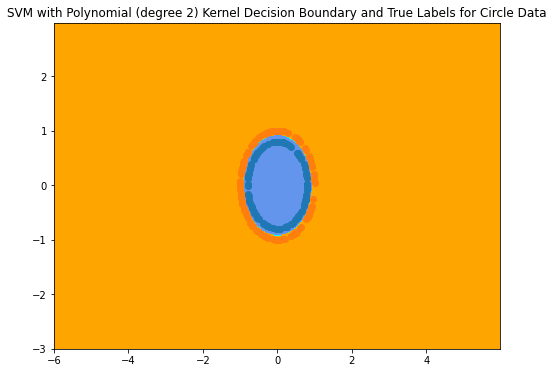

In [527]:
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('SVM with Polynomial (degree 2) Kernel Decision Boundary and True Labels for Circle Data')

In [910]:
# Kernel Logistic Regression
logr = Logistic(kernel='linear', iteration=100)
W, b = logr.fit(X_train_circle, Y_train_circle)
test_pred = logr.predict(X_test_circle)
print('test', accuracy_score(Y_test_circle, test_pred))

test 0.48


Text(0.5, 1.0, 'Logistic Regression with Linear Kernel Decision Boundary and True Labels for Circle Data')

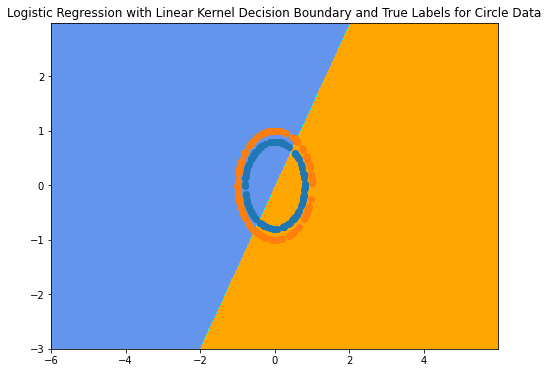

In [911]:
Z = logr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('Logistic Regression with Linear Kernel Decision Boundary and True Labels for Circle Data')

In [672]:
# Kernel Logistic Regression
logr = Logistic(kernel='poly', iteration=100, degree = 4, verbosity = False)
W, b = logr.fit(X_train_circle, Y_train_circle)
val_pred = logr.predict(X_val_circle)
print('val', accuracy_score(Y_val_circle, val_pred))
train_pred = logr.predict(X_train_circle)
print('train', accuracy_score(Y_train_circle, train_pred))

val 1.0
train 1.0


In [673]:
test_pred = logr.predict(X_test_circle)
print('test', accuracy_score(Y_test_circle, test_pred))
test_pred = logr.predict(X_test_circle)
print('test', accuracy_score(Y_test_circle, test_pred))

test 1.0
test 1.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Logistic Regression with Polynomial Kernel Decision Boundary and True Labels for Circle Data')

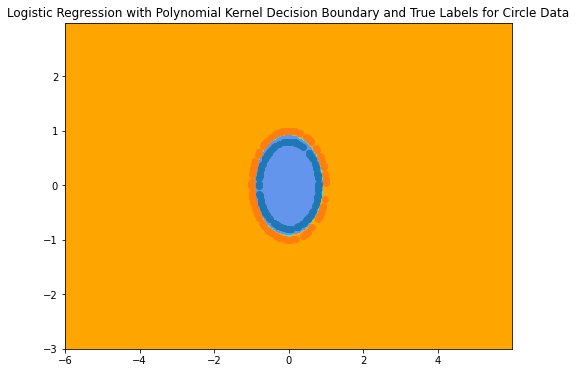

In [674]:
Z = logr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('Logistic Regression with Polynomial Kernel Decision Boundary and True Labels for Circle Data')

In [675]:
# Kernel Logistic Regression
logr = Logistic(kernel='rbf', iteration=1000, gamma = 1000, verbosity = False)
W, b = logr.fit(X_train_circle, Y_train_circle)
val_pred = logr.predict(X_val_circle)
print('val', accuracy_score(Y_val_circle, val_pred))
train_pred = logr.predict(X_train_circle)
print('train', accuracy_score(Y_train_circle, train_pred))

val 1.0
train 1.0


In [676]:
logr = Logistic(kernel='rbf', iteration=1000, gamma = 1000, verbosity = False)
W, b = logr.fit(X_train_circle, Y_train_circle)
test_pred = logr.predict(X_test_circle)
print('test', accuracy_score(Y_test_circle, test_pred))

test 1.0


Text(0.5, 1.0, 'Logistic Regression with RBF Kernel Decision Boundary')

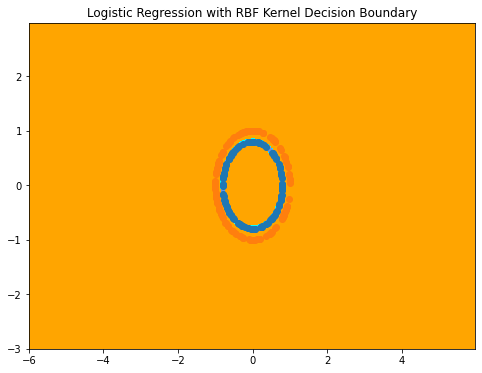

In [678]:
Z = logr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('Logistic Regression with RBF Kernel Decision Boundary')

In [695]:
# Neural Net
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
n_epochs = 30
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
input_size = 2
hidden_size1 = 300
hidden_size2 = 200
output_size = 1

In [842]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1,hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid
        self.softmax = nn.Softmax(dim=1)
        self.ReLU = F.relu
    def forward(self, x):
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [843]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=1e-5, momentum=0)
criterion = nn.BCEWithLogitsLoss()
train_losses = []
#train_counter = []
test_losses = []
#test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [844]:
# Converting numpy array to Tensor
X_train_circle_tensor = Variable(torch.from_numpy(X_train_circle).float())
Y_train_circle_tensor = Variable(torch.from_numpy(Y_train_circle.reshape(-1,1)).float())    

In [847]:
# train
for e in range(40000):
    output = network(X_train_circle_tensor)
    optimizer.zero_grad()
    #print(output.shape, Y_train_circle_tensor.shape)
    loss = criterion(output, Y_train_circle_tensor)
    if e%1000==0:
        print(loss)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

tensor(0.7290, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7289, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7288, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7287, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7286, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7285, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7284, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7283, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7282, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7281, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7279, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7278, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7277, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7276, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7275, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7274, grad_fn=<BinaryCrossEntropyWithLogitsBac

In [721]:
# Converting numpy array to Tensor
X_test_circle_tensor = Variable(torch.from_numpy(X_test_circle).float())
Y_test_circle_tensor = Variable(torch.from_numpy(Y_test_circle).long())    

In [848]:
# test
network.eval()
test_loss = 0
correct = 0
preds = []
with torch.no_grad():
    output = network(X_test_circle_tensor)
    #print(target.shape)
    #print('test_loss', test_loss)
    pred = output.data.max(1, keepdim=True)[1]
    #print(pred)
    preds.extend(pred.cpu().detach().numpy())

In [851]:
test_pred = output.cpu().detach().numpy()

In [860]:
accuracy_score(Y_test_circle, test_pred < 0.5)

0.456

In [ ]:
Z = best_model_neigh.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('KNN Decision Boundary and True Labels for Circle Data')

In [349]:
# KNN
test_accuracies_knn_circles = []
accuracy = 0
# tune hyperparameters
for n in [1, 2, 3, 5, 10]:
    neigh = KNN(n_neighbors=n)
    y_pred_nb = neigh.fit(train[['feat1', 'feat2']], train['labels']).predict(val[['feat1', 'feat2']])
    accuracy = accuracy_score(val['labels'], y_pred_nb)
    if accuracy>best_accuracy:
        best_model_neigh = neigh
    y_pred_nb = best_model_neigh.predict(test[['feat1', 'feat2']])
    test_accuracies_knn_circles.append(accuracy_score(test['labels'], y_pred_nb))

In [350]:
test_accuracies_knn_circles

[1.0, 1.0, 1.0, 1.0, 1.0]

Text(0.5, 1.0, 'KNN Decision Boundary and True Labels for Circle Data')

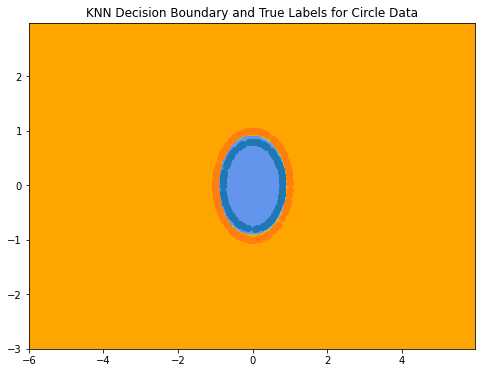

In [351]:
Z = best_model_neigh.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(post_test_circles['feat1'], post_test_circles['feat2'])
plt.scatter(neg_test_circles['feat1'], neg_test_circles['feat2'])
plt.title('KNN Decision Boundary and True Labels for Circle Data')

2.3 Real Dataset

In [352]:
from sklearn.datasets import load_breast_cancer

In [353]:
bc_data = load_breast_cancer()

In [357]:
df_bc = pd.DataFrame(bc_data['data'])
df_bc['labels'] = bc_data['target']

In [575]:
df_bc

0      1       2       3        4        5        6        7       8  \
0    17.99  10.38  122.80  1001.0  0.11840  0.27760  0.30010  0.14710  0.2419   
1    20.57  17.77  132.90  1326.0  0.08474  0.07864  0.08690  0.07017  0.1812   
2    19.69  21.25  130.00  1203.0  0.10960  0.15990  0.19740  0.12790  0.2069   
3    11.42  20.38   77.58   386.1  0.14250  0.28390  0.24140  0.10520  0.2597   
4    20.29  14.34  135.10  1297.0  0.10030  0.13280  0.19800  0.10430  0.1809   
..     ...    ...     ...     ...      ...      ...      ...      ...     ...   
564  21.56  22.39  142.00  1479.0  0.11100  0.11590  0.24390  0.13890  0.1726   
565  20.13  28.25  131.20  1261.0  0.09780  0.10340  0.14400  0.09791  0.1752   
566  16.60  28.08  108.30   858.1  0.08455  0.10230  0.09251  0.05302  0.1590   
567  20.60  29.33  140.10  1265.0  0.11780  0.27700  0.35140  0.15200  0.2397   
568   7.76  24.54   47.92   181.0  0.05263  0.04362  0.00000  0.00000  0.1587   

           9  ...     21      22      23       24       25      26      27  \
0    0.07871  ...  17.33  184.60  2019.0  0.16220  0.66560  0.7119  0.2654   
1    0.05667  ...  23.41  158.80  1956.0  0.12380  0.18660  0.2416  0.1860   
2    0.05999  ...  25.53  152.50  1709.0  0.14440  0.42450  0.4504  0.2430   
3    0.09744  ...  26.50   98.87   567.7  0.20980  0.86630  0.6869  0.2575   
4    0.05883  ...  16.67  152.20  1575.0  0.13740  0.20500  0.4000  0.1625   
..       ...  ...    ...     ...     ...      ...      ...     ...     ...   
564  0.05623  ...  26.40  166.10  2027.0  0.14100  0.21130  0.4107  0.2216   
565  0.05533  ...  38.25  155.00  1731.0  0.11660  0.19220  0.3215  0.1628   
566  0.05648  ...  34.12  126.70  1124.0  0.11390  0.30940  0.3403  0.1418   
567  0.07016  ...  39.42  184.60  1821.0  0.16500  0.86810  0.9387  0.2650   
568  0.05884  ...  30.37   59.16   268.6  0.08996  0.06444  0.0000  0.0000   

         28       29  labels  
0    0.4601  0.11890       0  
1    0.2750  0.08902       0  
2    0.3613  0.08758       0  
3    0.6638  0.17300       0  
4    0.2364  0.07678       0  
..      ...      ...     ...  
564  0.2060  0.07115       0  
565  0.2572  0.06637       0  
566  0.2218  0.07820       0  
567  0.4087  0.12400       0  
568  0.2871  0.07039       1  

[569 rows x 31 columns]

In [579]:
train_bc.drop('labels', axis = 1)

0      1       2       3        4        5         6         7   \
229  12.83  22.33   85.26   503.2  0.10880  0.17990  0.169500  0.068610   
397  12.80  17.46   83.05   508.3  0.08044  0.08895  0.073900  0.040830   
54   15.10  22.02   97.26   712.8  0.09056  0.07081  0.052530  0.033340   
536  14.27  22.55   93.77   629.8  0.10380  0.11540  0.146300  0.061390   
308  13.50  12.71   85.69   566.2  0.07376  0.03614  0.002758  0.004419   
..     ...    ...     ...     ...      ...      ...       ...       ...   
260  20.31  27.06  132.90  1288.0  0.10000  0.10880  0.151900  0.093330   
436  12.87  19.54   82.67   509.2  0.09136  0.07883  0.017970  0.020900   
408  17.99  20.66  117.80   991.7  0.10360  0.13040  0.120100  0.088240   
142  11.43  17.31   73.66   398.0  0.10920  0.09486  0.020310  0.018610   
518  12.88  18.22   84.45   493.1  0.12180  0.16610  0.048250  0.053030   

         8        9   ...     20     21      22      23       24       25  \
229  0.2123  0.07254  ...  15.20  30.15  105.30   706.0  0.17770  0.53430   
397  0.1574  0.05750  ...  13.74  21.06   90.72   591.0  0.09534  0.18120   
54   0.1616  0.05684  ...  18.10  31.69  117.70  1030.0  0.13890  0.20570   
536  0.1926  0.05982  ...  15.29  34.27  104.30   728.3  0.13800  0.27330   
308  0.1365  0.05335  ...  14.97  16.94   95.48   698.7  0.09023  0.05836   
..      ...      ...  ...    ...    ...     ...     ...      ...      ...   
260  0.1814  0.05572  ...  24.33  39.16  162.30  1844.0  0.15220  0.29450   
436  0.1861  0.06347  ...  14.45  24.38   95.14   626.9  0.12140  0.16520   
408  0.1992  0.06069  ...  21.08  25.41  138.10  1349.0  0.14820  0.37350   
142  0.1645  0.06562  ...  12.78  26.76   82.66   503.0  0.14130  0.17920   
518  0.1709  0.07253  ...  15.05  24.37   99.31   674.7  0.14560  0.29610   

          26       27      28       29  
229  0.62820  0.19770  0.3407  0.12430  
397  0.19010  0.08296  0.1988  0.07053  
54   0.27120  0.15300  0.2675  0.07873  
536  0.42340  0.13620  0.2698  0.08351  
308  0.01379  0.02210  0.2267  0.06192  
..       ...      ...     ...      ...  
260  0.37880  0.16970  0.3151  0.07999  
436  0.07127  0.06384  0.3313  0.07735  
408  0.33010  0.19740  0.3060  0.08503  
142  0.07708  0.06402  0.2584  0.08096  
518  0.12460  0.10960  0.2582  0.08893  

[455 rows x 30 columns]

In [878]:
from sklearn.preprocessing import StandardScaler

In [879]:
scaler = StandardScaler()

In [880]:
train_bc, val_bc, test_bc = train_val_test(df_bc, 455, 56)
X_train_bc = scaler.fit_transform(np.array(train_bc.drop('labels', axis = 1)))
Y_train_bc = np.array(train_bc['labels'])
X_val_bc = scaler.transform(np.array(val_bc.drop('labels', axis = 1)))
Y_val_bc = np.array(val_bc['labels'])
X_test_bc = scaler.transform(np.array(test_bc.drop('labels', axis = 1)))
Y_test_bc = np.array(test_bc['labels'])

In [583]:
X_test_bc.shape

(58, 30)

In [881]:
# Linear SVM
svm_linear.fit(X_train_bc, Y_train_bc)
y_pred_lsvm = svm_linear.predict(X_test_bc)
print(accuracy_score(Y_test_bc, y_pred_lsvm))

0.9827586206896551


In [882]:
# SVM linear kernel
svm = SVM(kernel='linear', C=100, iteration=60, degree = 2)
W, b = svm.fit(X_train_bc, Y_train_bc)
test_pred = svm.predict(X_test_bc)
print(accuracy_score(Y_test_bc, test_pred))

0.9482758620689655


In [883]:
# SVM linear kernel
for d in [2, 3, 4, 5, 6]:
    svm = SVM(kernel='poly', C=100, iteration=60, degree = d)
    W, b = svm.fit(X_train_bc, Y_train_bc)
    val_pred = svm.predict(X_val_bc)
    print(d, accuracy_score(Y_val_bc, val_pred))

2 0.8928571428571429
3 0.9642857142857143
4 0.7857142857142857
5 0.9285714285714286
6 0.8035714285714286


In [884]:
svm = SVM(kernel='poly', C=100, iteration=60, degree = 3)
W, b = svm.fit(X_train_bc, Y_train_bc)
test_pred = svm.predict(X_test_bc)
print(accuracy_score(Y_test_bc, test_pred))

0.9137931034482759


In [885]:
# SVM linear kernel
for gamma in [1, 100, 10000]:
    svm = SVM(kernel='rbf', iteration=60, gamma = gamma)
    W, b = svm.fit(X_train_bc, Y_train_bc)
    val_pred = svm.predict(X_val_bc)
    print(gamma, accuracy_score(Y_val_bc, val_pred))

1 0.6607142857142857
100 0.6607142857142857
10000 0.6607142857142857


In [886]:
svm = SVM(kernel='rbf', C=100, iteration=600, gamma=1)
W, b = svm.fit(X_train_bc, Y_train_bc)
test_pred = svm.predict(X_test_bc)
print(accuracy_score(Y_test_bc, test_pred))

0.6896551724137931


In [887]:
# Logistic Regression
logr = Logistic(kernel='no_kernel', iteration=50)
W, b = logr.fit(X_train_bc, Y_train_bc)
test_pred = logr.predict(X_test_bc)
print(accuracy_score(Y_test_bc, test_pred))

0.9482758620689655


In [888]:
# Logistic Regression
logr = Logistic(kernel='linear', iteration=50)
W, b = logr.fit(X_train_bc, Y_train_bc)
test_pred = logr.predict(X_test_bc)
print(accuracy_score(Y_test_bc, test_pred))

0.9827586206896551


In [889]:
# Logistic Regression
for d in [2, 3, 4, 5, 6]:
    logr = Logistic(kernel='poly', iteration=50, degree = d)
    W, b = logr.fit(X_train_bc, Y_train_bc)
    val_pred = logr.predict(X_val_bc)
    print(d, accuracy_score(Y_val_bc, val_pred))

2 0.6785714285714286
3 0.9821428571428571
4 0.5714285714285714
5 0.9821428571428571
6 0.4107142857142857


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


In [890]:
logr = Logistic(kernel='poly', iteration=50, degree = 3)
W, b = logr.fit(X_train_bc, Y_train_bc)
test_pred = logr.predict(X_test_bc)
print(accuracy_score(Y_test_bc, test_pred))

1.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


In [891]:
# Logistic Regression
logr = Logistic(kernel='rbf', iteration=50)
W, b = logr.fit(X_train_bc, Y_train_bc)
test_pred = logr.predict(X_test_bc)
print(accuracy_score(Y_test_bc, test_pred))

0.6896551724137931


In [892]:
# KNN
best_accuracy = 0
# tune hyperparameters
for n in [1, 5, 10, 15, 20]:
    neigh = KNN(n_neighbors=n)
    y_pred_nb = neigh.fit(X_train_bc, Y_train_bc).predict(X_val_bc)
    accuracy = accuracy_score(Y_val_bc, y_pred_nb)
    if accuracy>best_accuracy:
        best_model_neigh = neigh
        best_accuracy = accuracy
        print(n, accuracy)

1 0.9642857142857143
5 1.0


In [893]:
test_pred = best_model_neigh.predict(X_test_bc)
print(accuracy_score(Y_test_bc, test_pred))

0.9827586206896551


In [906]:
for c in [0.01, 1, 10, 100]:
    # Linear SVM
    svm = SVM_linear(C = c)
    W, b = svm_linear.fit(X_train_bc, Y_train_bc)
    y_pred_lsvm = svm_linear.predict(X_test_bc)
    print(c, accuracy_score(Y_test_bc, y_pred_lsvm))

0.01 0.9827586206896551
1 0.9827586206896551
10 0.9827586206896551
100 0.9827586206896551


In [908]:
max(abs(W))

0.572856206863481

In [909]:
boolArr = (abs(W) >= max(abs(W))*0.8)
bc_data['feature_names'][np.where(boolArr)]

array(['mean concavity', 'mean concave points', 'radius error',
       'worst texture', 'worst concavity', 'worst symmetry'], dtype='<U23')

In [896]:
for c in [0.01, 1, 10, 100, 1000]:
    # SVM linear kernel
    svm = SVM(kernel='linear', C=c, iteration=60)
    W, b = svm.fit(X_train_bc, Y_train_bc)
    test_pred = svm.predict(X_test_bc)
    print(c, accuracy_score(Y_test_bc, test_pred))

0.9827586206896551
1.0
1.0
0.9655172413793104
0.9655172413793104


(array([ 22,  93, 189, 302], dtype=int64),)

IndexError: index 93 is out of bounds for axis 0 with size 30